In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
from single_photons.utils.constants import *
from single_photons.environment import Particle

In [18]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 10*T, T/400)
N = t.shape[0]
delta_t = np.diff(t)[0]

In [19]:
gamma = 85
coupling = 0.01
eta_detec=0.9
env = Particle(omega, gamma, coupling, eta_detection=eta_detec)

In [20]:
variance_process = 2*env.__gamma__ + np.power(env.backaction, 2)
std_detection = 4

In [21]:
Q = np.array([[0, 0], [0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [22]:
Ad = np.eye(2)+env.A*delta_t+0.5*np.matmul(env.A*delta_t, env.A*delta_t)

In [23]:
P0 = 100*np.matrix(np.eye(2))
estimation = np.matrix([[0],[0]])
states = np.array([[100],[0.]])
K = np.array([[1, 1e5]])
new_states = np.zeros((N,2)) 
kalman = KalmanFilter(estimation, P0, Ad, env.B*delta_t, env.C, Q, R)
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0,:] = estimation.reshape((2))
estimation = estimation.reshape((2,1))
for i in tqdm(range(t.shape[0])):
    u = -np.matmul(K, estimation).sum()
    new_states[i,:] = states[:,0]
    measured_states[i] = states[0, 0] + std_detection*np.random.normal()
    kalman.propagate_dynamics(np.array([[u]]))
    kalman.compute_aposteriori(measured_states[i])
    estimated_states[i,:] = kalman.estimates_aposteriori[i][:,0].reshape((2))
    estimation = estimated_states[i,:].reshape((2,1))    
    states = env.step(states, control=u, delta_t=delta_t)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 5038.12it/s]


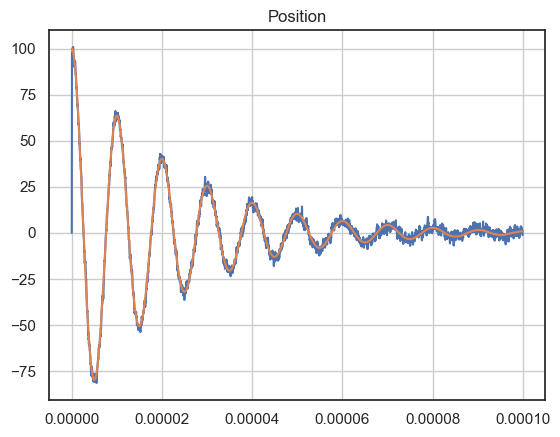

In [33]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, estimated_states[:,0])
plt.plot(t, new_states[:,0])
plt.grid()
plt.show()

In [25]:
z = estimated_states[:,0]*env.zp_x
p = estimated_states[:,1]*env.zp_p

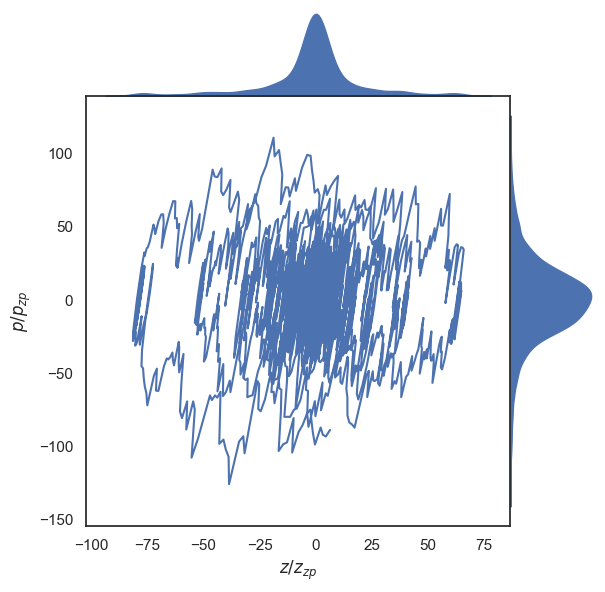

In [26]:
sns.set_theme(style="white")
df = pd.DataFrame()
df['z'] = estimated_states[100:,0]
df['p'] = estimated_states[100:,1]
g = sns.JointGrid(data=df, x="z", y="p", space=0)
g.plot_joint(sns.lineplot, sort = False)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')

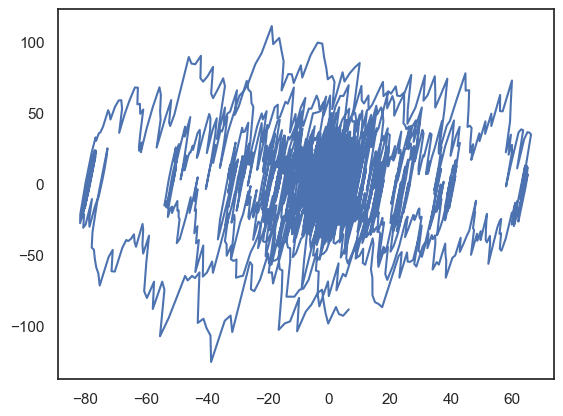

In [27]:
plt.plot(df['z'], df['p'])

In [28]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
cov_mat

matrix([[   4.38134092,   44.24232617],
        [  44.24232617, 1068.02087968]])

In [29]:
estimated_states[-30:].var(axis=0)

array([  2.62312317, 191.82738379])

In [34]:
(env._m_*np.power(env.__omega__, 2)*np.power(z_std,2)+np.power(p_std,2)/env._m_)/(2*hbar*env.__omega__)

0.22116627475764986

In [37]:
z_std*p_std > hbar/2

True